##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Factor Analysis (with TFP)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Factor_Analysis_TFP.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Factor_Analysis_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content [this Repository](https://github.com/blei-lab/edward/blob/master/examples/factor_analysis.py), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/)

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Sri Thatipamala([`@sridatta`](https://twitter.com/sridatta)), Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- Dependencies & Prerequisites
- Introduction
  - What is Factor Analysis?
  - How does Factor Analysis work?
  - Factor Analysis vs. Probabilistic PCA
  - Our Example
- Data
- Model
- E-Step (EM Part 1): Hamiltonian Monte Carlo Inference
- M-Step (EM Part 2): Maximum a Posteriori Inference
- Running the Full Inference
- Conclusions
- References


## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
!pip3 install -q observations
!pip3 install -q imageio
from __future__ import absolute_import, division, print_function

#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
from imageio import imsave
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow_probability import edward2 as ed
  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.

    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config

def strip_consts(graph_def, max_const_size=32):
    """
    Strip large constant values from graph_def.
    """
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
      n = strip_def.node.add()
      n.MergeFrom(n0)
      if n.op == 'Const':
        tensor = n.attr['value'].tensor
        size = len(tensor.tensor_content)
        if size > max_const_size:
          tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def


def draw_graph(model, *args, **kwargs):
    """
    Visualize TensorFlow graph.
    """
    graph = tf.Graph()
    with graph.as_default():
      model(*args, **kwargs)
    graph_def = graph.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=32)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    IPython.display.display(IPython.display.HTML(iframe))

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


# from edward.models import Bernoulli, Empirical, Normal
from observations import mnist
from scipy.misc import imsave # imsave is deprecated! imsave is deprecated in SciPy 1.0.0, and will be removed in 1.2.0. Use imageio.imwrite instead.


## Introduction

### What is Factor Analysis?
When we have data, we often have many (correlated) samples. Often times the variability in our samples is due to the effects of a set of unobserved, underlying variables (also known as "factors"). Specifically, we can describe the variability in terms of a number of unobserved variables that's lower than the number of obvervefd variables (e.g., variations in 12 observed variables being due to variation in just 3 hidden variables).

### How does Factor Analysis Work?

In many problems we only have a dataset $X = \{x_1, x_2, \dots, x_n \}$, that we want to describe mathematically. In the case of unsupervised learning, we can describe $X$ as being the result of a continuous latent variable (with the vector $h_i$ being the latent variable in our case) model, as follows: 

$$
x_i = W h_i + \mu + \epsilon
$$

In this context we use "latent" to refer to any unobserved variables or factors. In our model, $ϵ$ described Gaussian noise that follows a Normal distriution with mean $0$ and covariance $Ψ$ (i.e. $ϵ∼\text{Normal}(0,Ψ)$). The vector $μ$ serves as an offset (or "bias") term. 

To convert this model into a form compatible with multiple $x_i$‘s (with each element being columns to form a matrix), the $x_i$'s form a matrix $\bf{X}$, the $h_i$‘s as columns form a matrix $\bf{H}$, and after applying the same strategy to the offset and noise ($\mu$ and $\epsilon$ become the matrices $\bf{M}$ and $\bf{E}$) then we can re-write our model as a decomposition of our data matrix $\bf{X}$:

$$\bf{X} = \textit{W} \bf{H} + \bf{M} + \bf{E}$$

If the latent variable $h_i$ is given, then the following probabilistic interpretation is implied for $\bf{X}$ given $\bf{H}$:
$$
p(x_i|h_i)=\text{Normal}(\text{mean}=Wh_i+μ\text{, covariance}=Ψ)
$$
However if we just have the data, then obviously $h_i$ *isn't* given (that's why we're doing this tutorial). To get $h_i$, we will be sampling from a probabilistic model. For the complete model we need a prior distribution for $h$. The simplest assumption we can make is that $h∼\text{Normal}(0,\bf{I})$. This means that we can represent the marginal distribution of  our data $x$ with the following:
$$
p(x)=\text{Normal}(\text{mean}=μ\text{, covariance}=WW^T+Ψ)
$$

As you might have observed with this model,  having $Ψ$ doesn't really seem necessary unless we have some assumptions about our latent variable(s) $h$, since our data can be modelled with a simple mean and covariance without need for latent variables. From here, the different assumptions we make about the error covariance $Ψ$ lead to two possible methods for us to use:

- **Assumption Option #1:** $Ψ=σ^2\bf{I}$: This assumption leads to the probabilistic version of **Principal Component Analysis** (PPCA; see the [tensorflow probability example here](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb)).

- **Assumption Option #2:** $Ψ=\text{diag}(ψ_1,ψ_2,…,ψ_n)$: This model is our **Factor Analysis** that we describe in this notebook, a classical statistical model. 

### Factor Analysis vs Probabilistic PCA

Factor analysis is closely related to principal component analysis (PCA), but it's important to stress that the two are _*not*_ identical.

<img src="https://github.com/matthew-mcateer/external_project_images/blob/master/PCA_vs_FA.png?raw=true" >

Principal compaonent analysis takes data, and reduces it to the axis along which there is the most variance. Principal component analysis is all about taking higher dimensional data, and then representing it in a lower-dimensional space.

With exploratory Factor analysis, the opposite happens: lower-dimensional latent factors are extrapolated as the dependencies of a more complex and larger observed dataset.

To summarize, **Principal component analysis** involves extracting linear composites of observed variables.

**Factor analysis** is based on a formal model predicting observed variables from theoretical latent factors.

How do you decide whether to use PCA or Factor Analysis? In terms of a simple rule of thumb, We'd suggest that you:

1. Run factor analysis if you assume or wish to test a theoretical model of latent factors causing observed variables.

2. Run principal component analysis If you want to simply reduce your correlated observed variables to a smaller set of important independent composite variables.

In our case, we're interested in testing a model for latent factors that can be used to represent a higher-dimensional image, namely an image of a handwritten digit.

### Our Example

For this demonstration, we're doing Factor Analysis on MNIST. To find out latent factors, we'll be using using Monte Carlo expectation-mazimization (EM). For the E-step, we'll be using Hamiltoniam Monte Carlo. For the M-step, we'll be using Maximum A Posteriori estimation. See [*Convergence of a stochastic approximation version of the EM algorithm*][[1]](#scrollTo=kTpcVhJKRp2f) for more details. 

More precisely, we use HMC to form a chain conditioned on parameter `sigma` and training data `{ (x[i], y[i]) : i=1...n }`. Then we use one gradient step of maximum-likelihood to improve the `sigma` estimate. Then repeat the process until convergence. (This procedure is a [Robbins--Monro algorithm](https://en.wikipedia.org/wiki/Stochastic_approximation).)

Using `tensorflow_probability` intrinsics, we can implement a stochastic approximation of Expectation Maximization (SAEM) . [*Bernard (1999)*][[1]](#scrollTo=kTpcVhJKRp2f)

We fit our latent factors to just one data point in MNIST (e.g., we're doing factor analysis on just one $28 \times 28$ image in the MNIST dataset).



In [0]:
#@title ## Hyperparameters { run: "auto" }
#@markdown Data download directory (default: /tmp/data)
data_dir = "/tmp/data"  #@param {type:"string"}
#@markdown Data output directory (default: /tmp/out)
out_dir = "/tmp/out"    #@param {type:"string"}
#@markdown Number of data points (default: 1)
num_datapoints = 1     #@param {type:"slider", min:1, max:2, step:1}
N = num_datapoints
#@markdown Number of latent dimensions (default: 10)
latent_dim = 10    #@param {type:"slider", min:1, max:10, step:1}
d = latent_dim
#@markdown Number of iterations per training epoch (default: 5000)
n_iter_per_epoch = 5000 #@param {type:"slider", min:200, max:5000, step:200}
#@markdown Number of training epochs (default: 20)
n_epoch = 20 #@param {type:"slider", min:0, max:50, step:1}

if not os.path.exists(out_dir):
    os.makedirs(out_dir)


## Data

For this Factor analysis, we're going to be demonstrating it on the [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database). This is a collection of handwritten digits, in the form of greyscale $28 \times 28$ images. By greyscale, we mean that the pixel brightness is represented by a single value ranging from $0$ to $255$, rather than a hexadecimal number or 3-number code representing RGB values. These images can also be represented as $1 \times 784$ arrays that can be reshaped into $28 \times 28$ images.

>> Downloading /tmp/data/train-images-idx3-ubyte.gz.part 
>> [9.5 MB/9.5 MB] 105% @39.8 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz downloaded to /tmp/data/train-images-idx3-ubyte.gz 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 35730), raddr=('74.125.31.128', 443)>
  download_file(url, filepath, hash_true, resume)


>> Downloading /tmp/data/train-labels-idx1-ubyte.gz.part 
>> [28.2 KB/28.2 KB] 3630% @47.7 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz downloaded to /tmp/data/train-labels-idx1-ubyte.gz 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 35736), raddr=('74.125.31.128', 443)>
  download_file(url, filepath, hash_true, resume)


>> Downloading /tmp/data/t10k-images-idx3-ubyte.gz.part 
>> [1.6 MB/1.6 MB] 127% @14.6 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz downloaded to /tmp/data/t10k-images-idx3-ubyte.gz 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 35744), raddr=('74.125.31.128', 443)>
  download_file(url, filepath, hash_true, resume)


>> Downloading /tmp/data/t10k-labels-idx1-ubyte.gz.part 
>> [4.4 KB/4.4 KB] 23086% @61.0 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz downloaded to /tmp/data/t10k-labels-idx1-ubyte.gz 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 34026), raddr=('64.233.170.128', 443)>
  download_file(url, filepath, hash_true, resume)


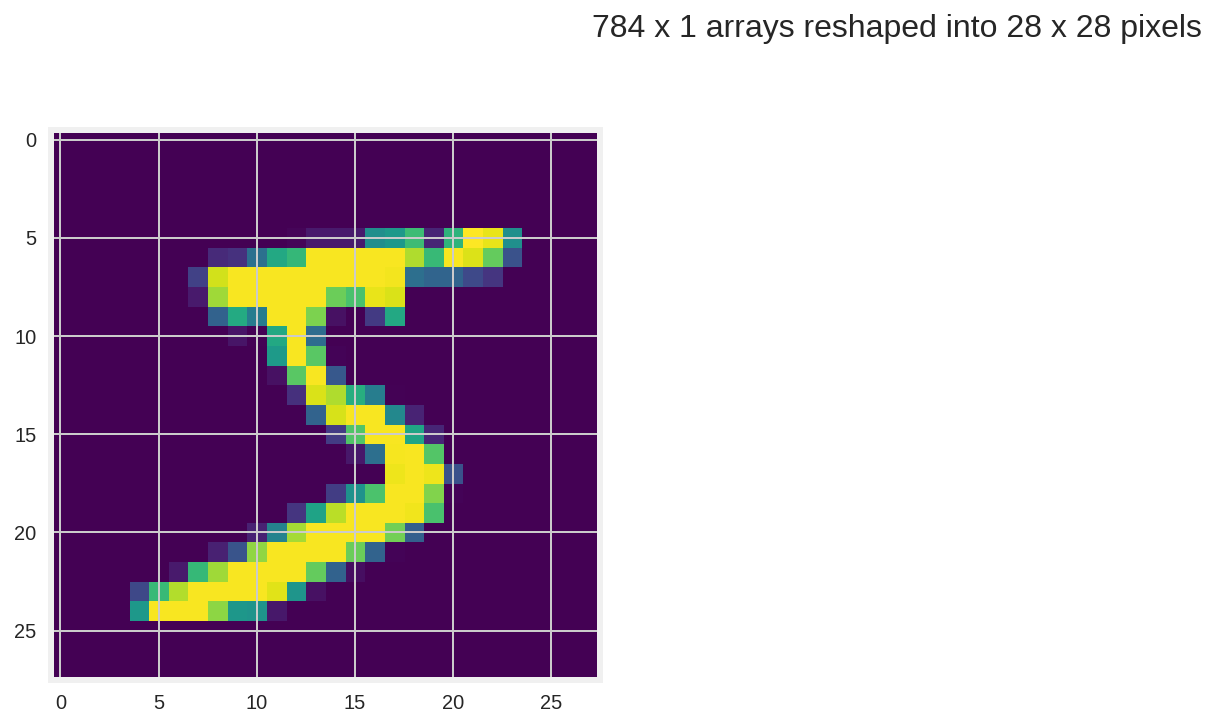

In [0]:
# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

(x_train, _), (x_test, _) = mnist(data_dir)
x_train = x_train[:num_datapoints]

n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (28, 28)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap='viridis'):
    plt.figure(figsize=(4. * n_col, 5.02 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest')
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

plot_gallery("784 x 1 arrays reshaped into 28 x 28 pixels", x_train)

## Model

For the sake of this example, we assume that the observations (i.e., the digits from MNIST) are be caused by a linear transformation of lower dimensional latent factors and added Gaussian noise. Without loss of generality the factors are distributed according to a Gaussian with zero mean and unit covariance. The noise is also zero mean and has an arbitrary diagonal covariance matrix.

From our model described above: $ x_i = W h_i + \mu + \epsilon $, such a model is called “generative” as it describes how $x_i$ is generated from $h_i$

If we would restrict the model further, by assuming that the Gaussian noise is even [isotropic](https://en.wikipedia.org/wiki/Isotropy) (all diagonal entries are the same, meaning the covariance is the same in all direction) we would obtain [Probabilistic PCA](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb).

FactorAnalysis performs a maximum likelihood estimate of the so-called loading matrix, the transformation of the latent variables to the observed ones, using [expectation-maximization (EM)](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

sample latent factors
 Tensor("Normal/sample/Reshape:0", shape=(1, 10), dtype=float32)

logits for the Bernoulli
 Tensor("sequential/reshape/Reshape:0", shape=(1, 1, 784), dtype=float32)

Our Mock x outputs
 Tensor("Bernoulli/sample/Reshape:0", shape=(1, 1, 784), dtype=int32)


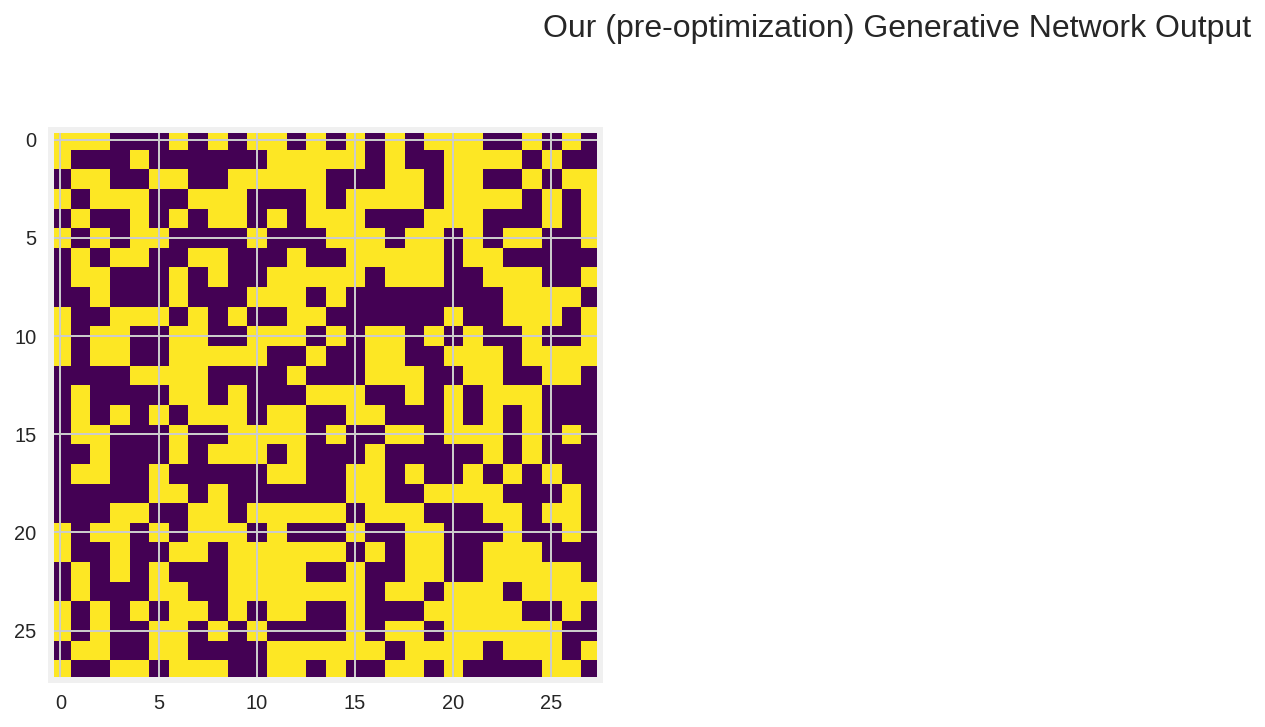

In [0]:
# MODEL
z = tfd.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
               scale=tf.ones([num_datapoints, latent_dim]))

generative_network = tf.keras.Sequential([
  tf.keras.layers.Dense(28*28, activation=None, input_shape=(latent_dim, )),
  tf.keras.layers.Reshape([num_datapoints, -1])
])

logits = generative_network(z.mean())
x = tfd.Bernoulli(logits=logits).sample()

evaluate(tf.global_variables_initializer())
print("sample latent factors\n", z.sample())
print("\nlogits for the Bernoulli\n", logits)
print("\nOur Mock x outputs\n", x)
plot_gallery("Our (pre-optimization) Generative Network Output", evaluate(x))

So now we've created out model. Looking at this output, you might not think this is a particularly accurate generative network, but that's because we haven't optimized it yet. The whole point of this is that we're taking this 10-element array, and mapping that to a $28 \times 28$ output. With enough training these $N$ latent variables will be mappable to an output that looks like something directly out of MNIST.

Now we can move onto the expectation maximization algorithm. 

An expectation–maximization (EM) algorithm is a method for finding maximum a posteriori (MAP) estimates of parameters in statistical models, where the model depends on unobserved latent variables. The EM iteration alternates between performing an expectation (E) step, which creates a function for the expectation of the log-likelihood evaluated using the current estimate for the parameters, and a maximization (M) step, which computes parameters maximizing the expected log-likelihood found on the E step. These parameter-estimates are then used to determine the distribution of the latent variables in the next E step.


## E-Step (EM Part 1): Hamiltonian Monte Carlo Inference

In the expectation step, we use a Monte Carlo method to sample among the prior distribution **$z$** that we have created. We define our model by setting up a loss function that takes in both the sample taken from the sampler, as well as the training data `x_train`.

In [0]:
def make_z_prior(num_datapoints, latent_dim):
    return tfd.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                      scale=tf.ones([num_datapoints, latent_dim]))

z_prior = make_z_prior(num_datapoints, latent_dim)

def make_response_likelihood(qz_sample):
    x = tfd.Bernoulli(logits=generative_network(qz_sample))
    return x

# This is our log prob function here
# the input needs to be a number, not a distribution
def unnormalized_posterior_log_prob(qz_sample):
    """Colosure over x_train"""
    likelihood = make_response_likelihood(qz_sample)
    return (z_prior.log_prob(qz_sample)
            + tf.reduce_sum(likelihood.log_prob(x_train), axis=-1))  # [m]
  

In [0]:
dtype = np.float32
dims = latent_dim
qz_sample_chain_start = tf.placeholder(
    tf.float32, [num_datapoints, latent_dim], 
    name="qz_sample_chain_start")

with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=np.array(0.05, dtype),
        use_resource=True,
        trainable=False)

#@markdown As you can see, we have a two-step HMC, instead of using hundreds or thousands
num_results = 2   #@param {type:"slider", min:1, max:3, step:1}
burnin = 0        #@param {type:"slider", min:0, max:1, step:1}
leapfrog = 2      #@param {type:"slider", min:0, max:5, step:1}

qz_sample, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=burnin,
    current_state=qz_sample_chain_start,
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=leapfrog,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
        state_gradients_are_stopped=True))

avg_acceptance_ratio = tf.reduce_mean(
    tf.exp(tf.minimum(kernel_results.log_accept_ratio, 0.)))

## M-Step (EM Part 2): Maximum a Posteriori Inference

Like in our We first search for the point estimate of latent variables that maximizes the posterior probability density. This is known as maximum a posteriori (MAP) inference, and is done by calculating the values of $\mathbf{Z}$ that maximise the posterior density $p(\mathbf{Z} \mid \mathbf{X}) \propto p(\mathbf{Z}, \mathbf{X})$.

In [0]:
# We do an optimization step to propagate `log_sigma` after two HMC steps to
# propagate `weights`.
loss = -tf.reduce_sum(kernel_results.accepted_results.target_log_prob)
#loss = tf.losses.absolute_difference(tf.reduce_sum(kernel_results.accepted_results.target_log_prob))

lr = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)


## Running the Full Inference


Epoch #0

log p(x) >= -14753490101.829


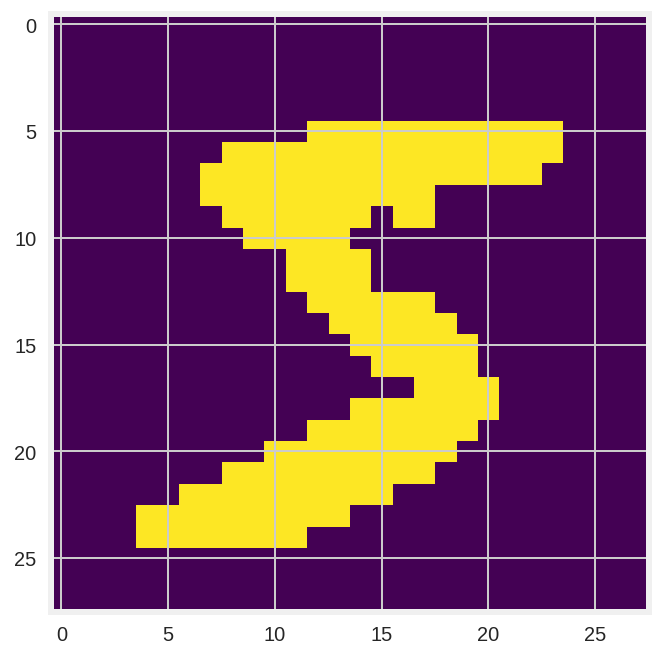

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #1

log p(x) >= -42891699603.046


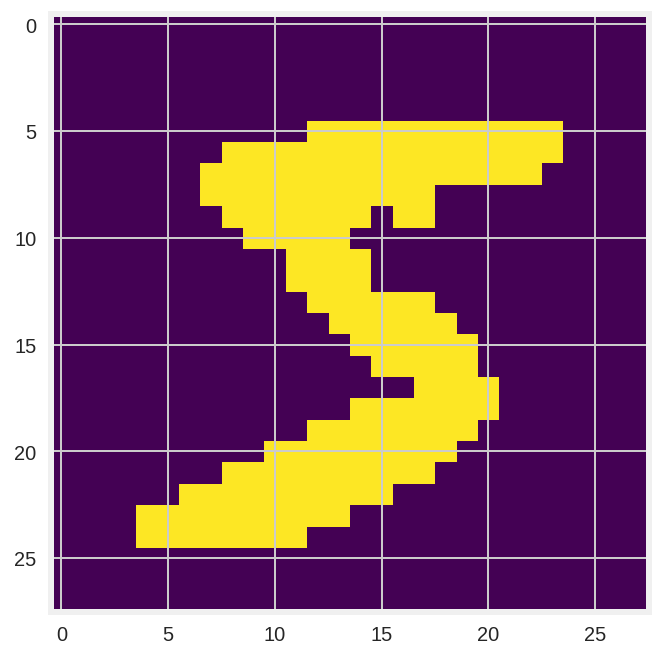

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #2

log p(x) >= -70963067539.456


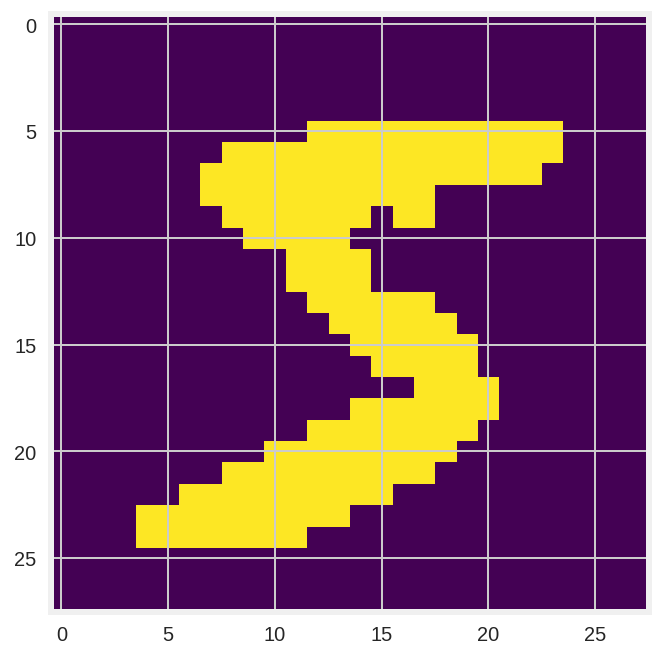

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #3

log p(x) >= -99027359295.078


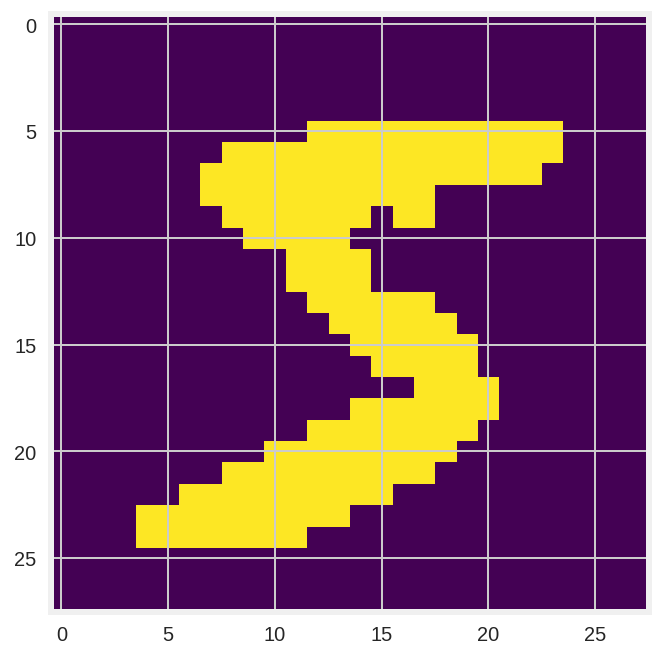

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #4

log p(x) >= -127074489021.235


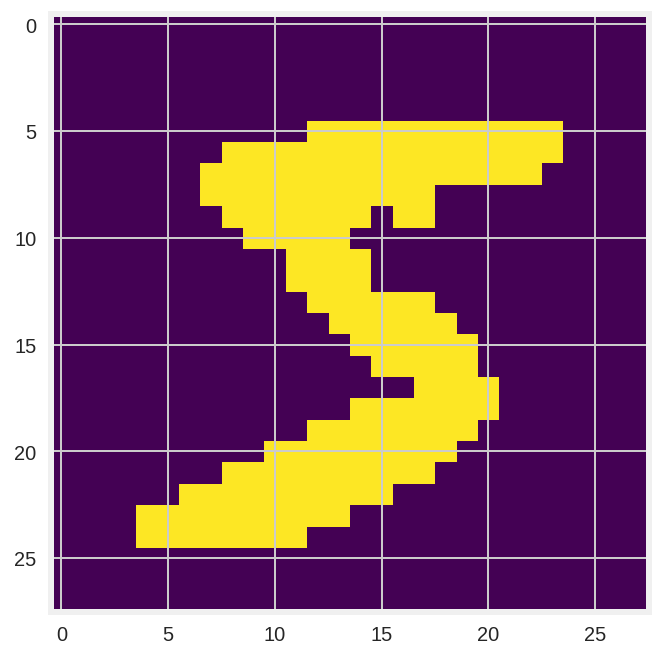

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #5

log p(x) >= -155121229909.197


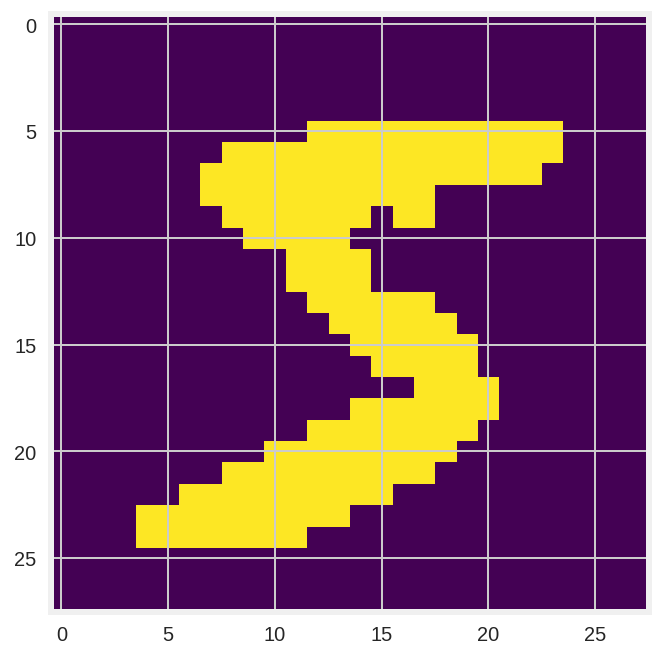

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #6

log p(x) >= -183167974431.130


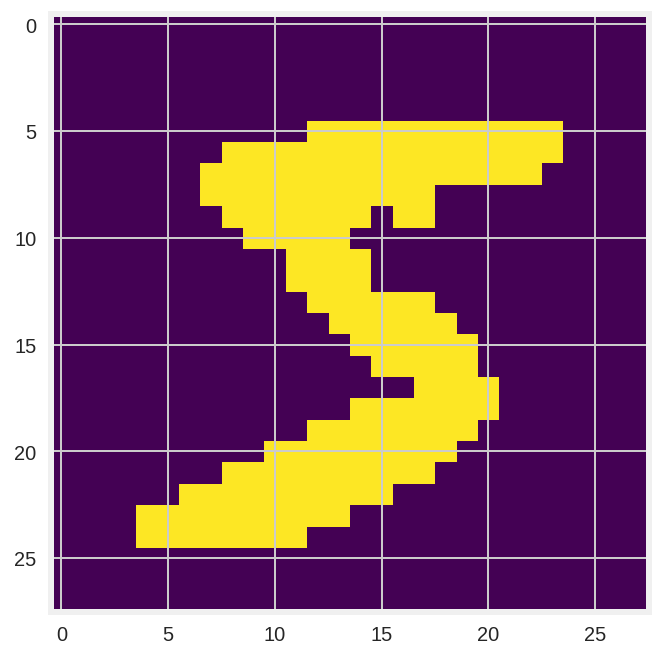

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #7

log p(x) >= -211214715787.674


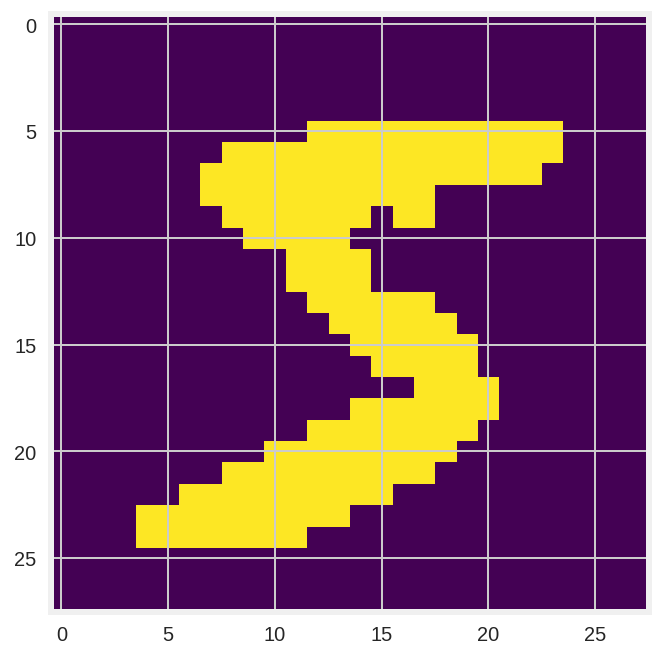

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #8

log p(x) >= -239261454578.483


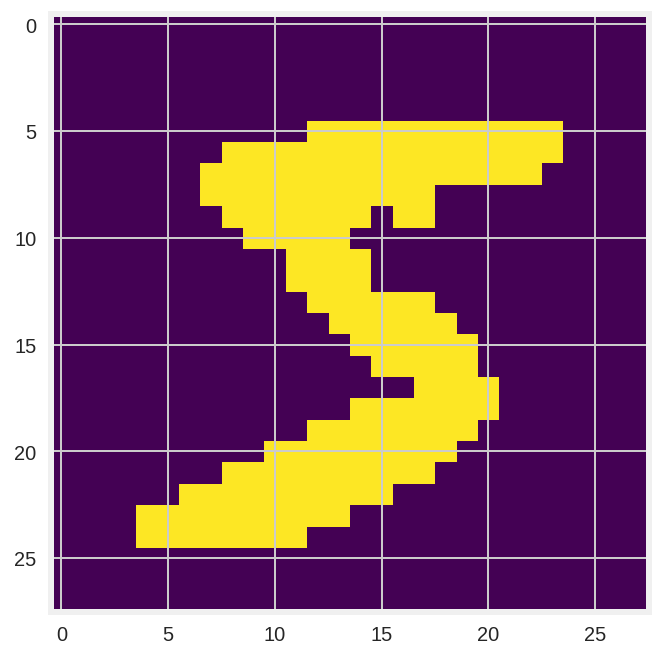

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #9

log p(x) >= -267308192841.728


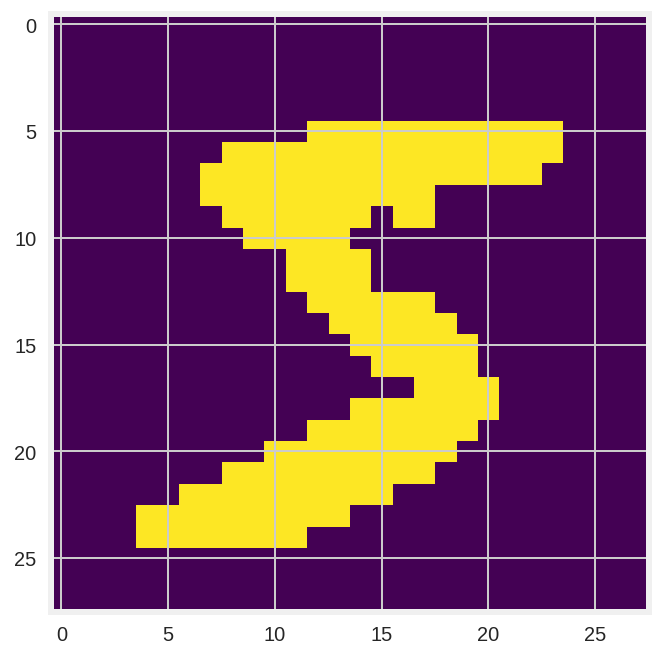

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #10

log p(x) >= -295354931465.421


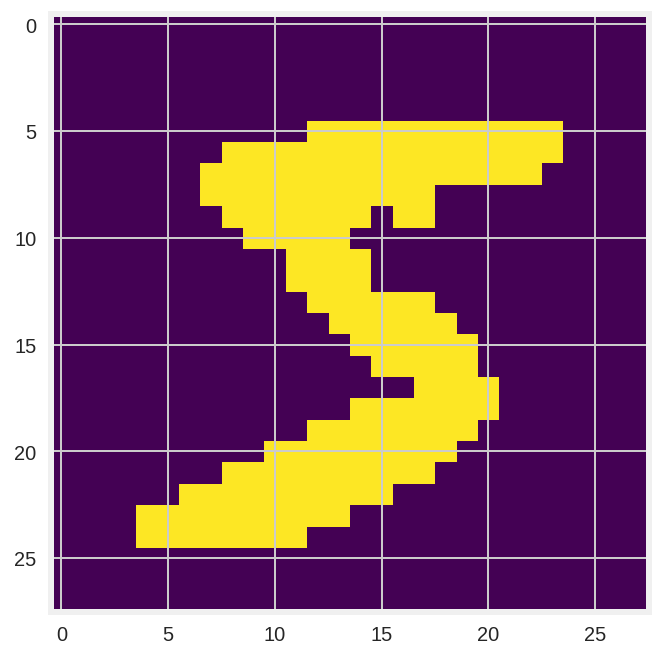

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #11

log p(x) >= -323401670479.053


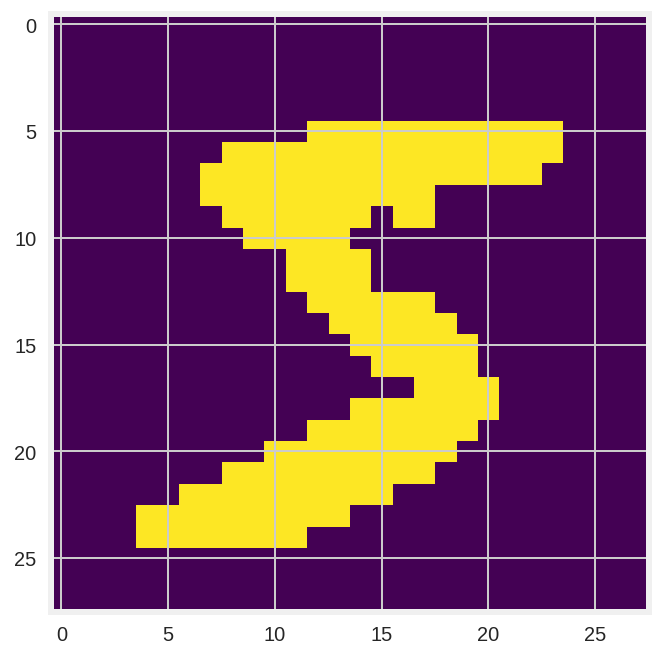

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #12

log p(x) >= -351448415607.194


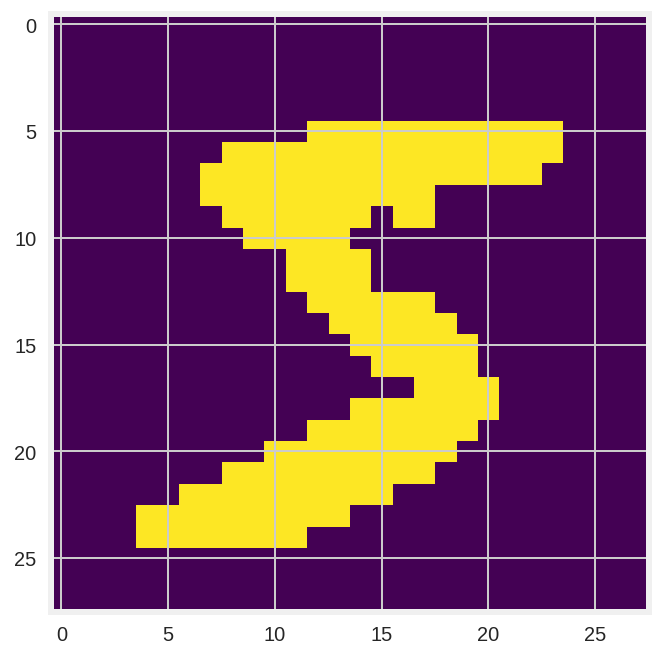

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #13

log p(x) >= -379495164405.350


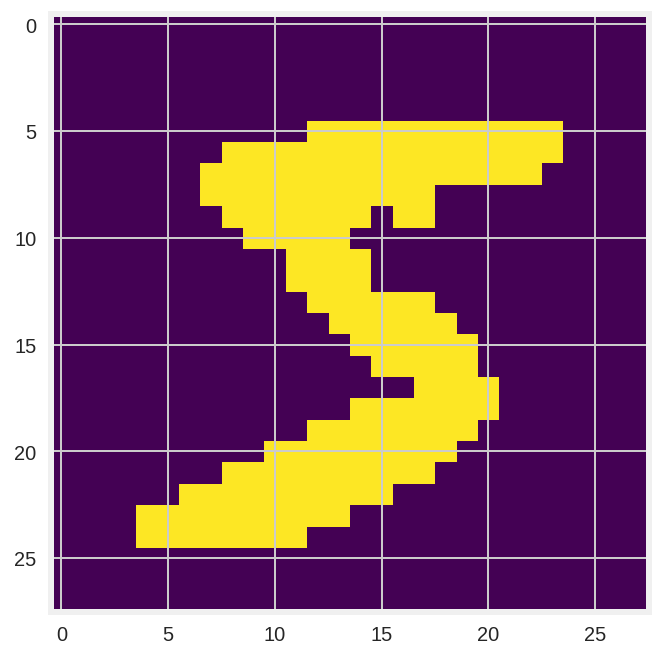

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #14

log p(x) >= -407541902973.338


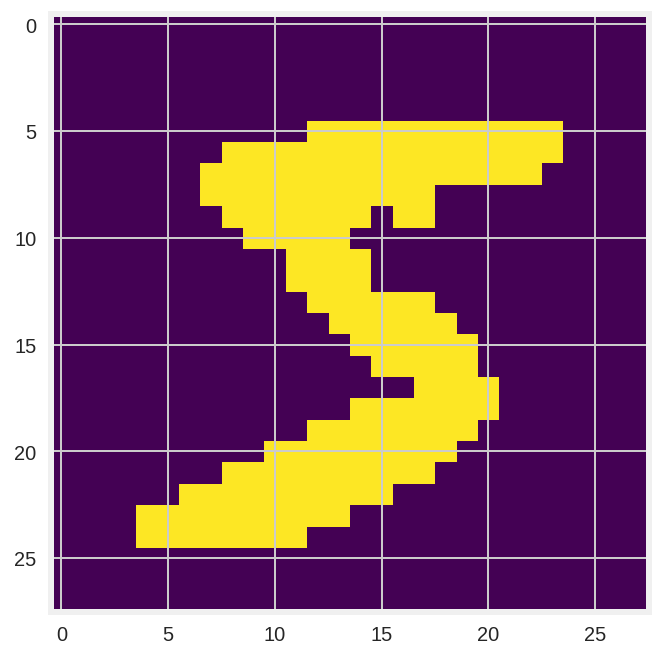

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #15

log p(x) >= -435588641862.451


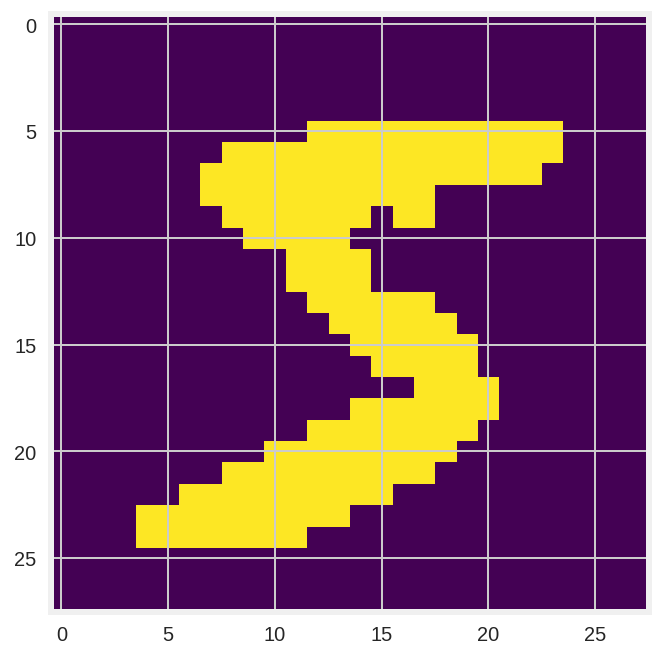

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #16

log p(x) >= -463635380692.582


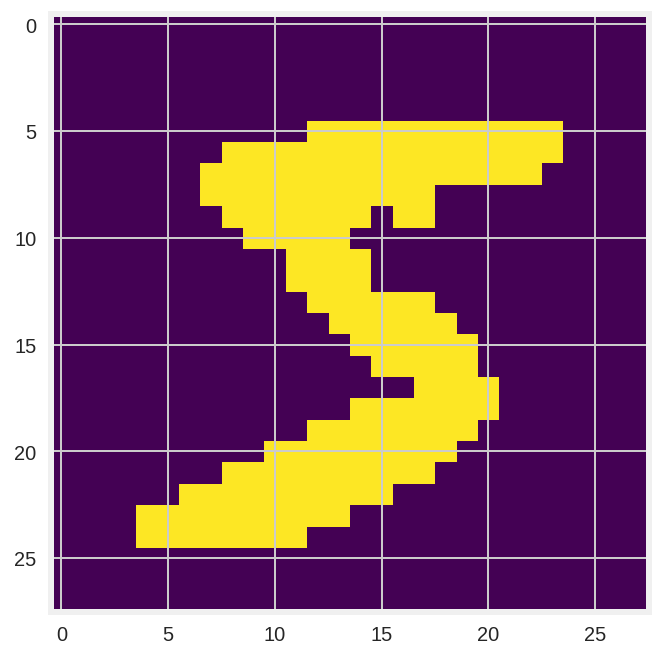

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #17

log p(x) >= -491682119647.232


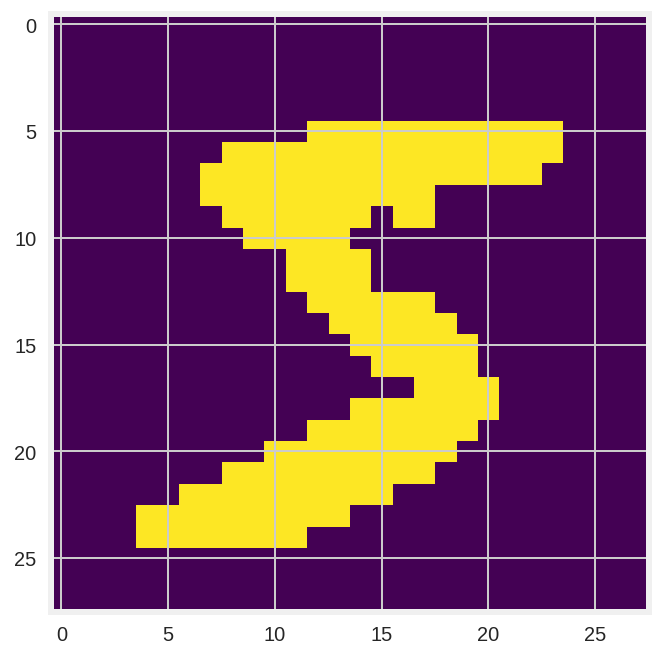

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]
Epoch #18

log p(x) >= -519728858680.525


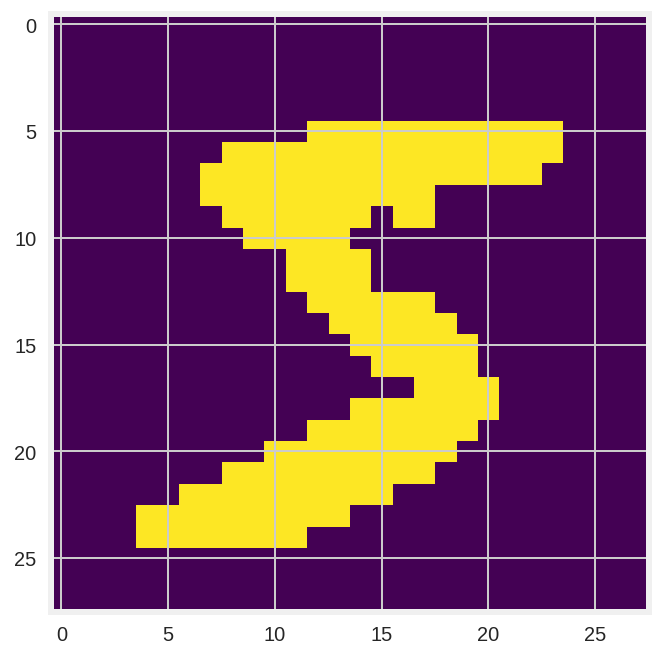

Latent variables: 
 [[ -917.8989   1025.7357  -1014.9249  -1011.0204   1086.2577   1026.8864
  -1004.35144 -1079.2723   1012.3144  -1077.3479 ]]


In [0]:
init_op = tf.global_variables_initializer()

num_iters = 5
losses_ = np.zeros([num_iters], dtype)
step_sizes_ = np.zeros([num_iters], dtype)
avg_acceptance_ratios_ = np.zeros([num_iters], dtype)


logits = generative_network(qz_sample_chain_start)
x = tfd.Bernoulli(logits=logits).sample()

evaluate(init_op)

last_qz = 0.1 * np.ones([num_datapoints, latent_dim], dtype=np.float32)
for _ in range(n_epoch - 1):
    avg_loss = 0.0
    for i in range(n_iter_per_epoch):
        # [train_op_, loss_, qz_sample_] = evaluate([train_op, loss, qz_sample])
        [train_op_, loss_, qz_sample_] = sess.run([train_op, loss, qz_sample], feed_dict={qz_sample_chain_start: last_qz})
        last_qz = qz_sample_[-1]
        avg_loss += loss_

    # Print a lower bound to the average marginal likelihood for an image.
    avg_loss = avg_loss / n_iter_per_epoch
    avg_loss = avg_loss / N
    print("Epoch #{}".format(_))
    print("\nlog p(x) >= {:0.3f}".format(avg_loss))

    # Prior predictive check.
    images = sess.run(x, feed_dict={qz_sample_chain_start: last_qz})
    #images = evaluate(x)
    for m in range(N):
        #imageio.imwrite(os.path.join(out_dir, '%d.png') % m,
        #     images[m].reshape(28, 28))
        if (m % 100) == 0:
            plt.imshow(images[m].reshape(28, 28), cmap='viridis')
            plt.show()
            print("Latent variables: \n",last_qz)
    final_image = images

## Conclusions

As we can see, from loading some of these test results we can see how we can create a generative model that can produce something as complext as a handwritten digit, from only a small number of latent factors. This is a very specific model of how factor analysis is done on images. One of the benefits of this type of Factor analysis (over another, say Heirarchical Convolutional Factor analysis [[3][4]](#scrollTo=kTpcVhJKRp2f)) is the ability to converge on reasonable results with fewer steps.

## References

[1] Bernard Delyon, Marc Lavielle, Eric, Moulines. Convergence of a stochastic approximation version of the EM algorithm, Ann. Statist. 27 (1999), no. 1, 94--128. https://projecteuclid.org/euclid.aos/1018031103

[2] W. Hao, M. Song, and J. D. Storey. Probabilistic models of genetic variation in structured populations applied to
global human studies. arXiv:1312.2041, 2013.

[3] B. Chen, G. Polatkan, G. Sapiro, D. Dunson and L. Carin, " The Hierarchical Beta Process for Convolutional Factor Analysis and Deep Learning", Proc. Int. Conf. Machine Learning (ICML), 2011

[4] B. Chen, G. Polatkan, G. Sapiro, D. Blei, D. Dunson and L. Carin,  "Deep Learning with Hierarchical Convolutional Factor Analysis", IEEE Trans. Pattern Analysis & Machine Intelligence, 2013.